# HW 8


# Задание  
На вебинаре мы говорили что долгое время CNN и RNN архитектуры были конурируещими выяснить какая архитектура больше подходит для задачи сантимент анализа на данных с вебинара
1. построить свёрточные архитектуры
2. построить различные архитектуры с RNN
3. построить совместные архитектуры CNN -> RNN и (RNN -> CNN)
4. сдлать выводы что получилось лучше

In [1]:
#  Возьмем датасет с прошлого занятия
import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_val = pd.read_csv("data/val.csv")

In [2]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [3]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [4]:
#  Цитата из гитхаба ...
#
# AttributeError: module 'keras.utils.generic_utils' has no attribute 'populate_dict_with_module_objects'
#
# dear keras-team, do you have any plan to release a newer stable version of Keras? 
# Currently, the stable Keras 2.4.3 does not work with TensorFlow 2.5.0 due to 
# the error reported in this issue.
#
# Поэтому возьмем keras из tensorflow
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
#import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, concatenate, Flatten, add, MaxPool1D
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Masking, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping  


In [5]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [6]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [7]:
y_train = df_train['class'].values
y_val = df_val['class'].values

In [8]:
def plot_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
    fig.suptitle('Horizontally stacked subplots')
       
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train', 'test'], loc='upper left')


# LSTM NN 1

In [9]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

x = LSTM(64, return_sequences=True)(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 27, 30)            7743240   
_________________________________________________________________
lstm (LSTM)                  (None, 27, 64)            24320     
_________________________________________________________________
flatten (Flatten)            (None, 1728)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                110656    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65    

Epoch 1/25
709/709 [==============================] - 153s 211ms/step - loss: 0.5315 - accuracy: 0.7232 - val_loss: 0.5004 - val_accuracy: 0.7489
Epoch 2/25
709/709 [==============================] - 143s 202ms/step - loss: 0.2795 - accuracy: 0.8857 - val_loss: 0.6163 - val_accuracy: 0.7413
Epoch 3/25
709/709 [==============================] - 141s 199ms/step - loss: 0.1209 - accuracy: 0.9547 - val_loss: 0.8004 - val_accuracy: 0.7315
Epoch 4/25
709/709 [==============================] - 141s 199ms/step - loss: 0.0690 - accuracy: 0.9750 - val_loss: 0.9675 - val_accuracy: 0.7246


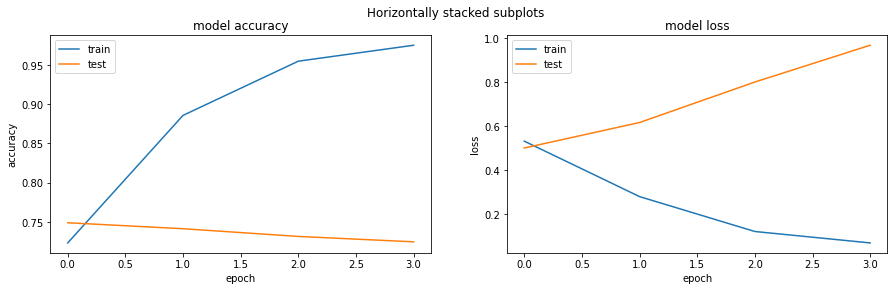

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [11]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 8s 12ms/step - loss: 0.5004 - accuracy: 0.7489


[0.5004479289054871, 0.7488868236541748]

# LSTM NN 2

In [12]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

xbi = Bidirectional(LSTM(15, return_sequences=True))(x)
x = add([x, xbi])

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 27, 30)       7743240     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 27, 30)       5520        embedding_1[0][0]                
__________________________________________________________________________________________________
add (Add)                       (None, 27, 30)       0           embedding_1[0][0]                
                                                                 bidirectional[0][0]        

Epoch 1/25
709/709 [==============================] - 260s 357ms/step - loss: 0.5322 - accuracy: 0.7225 - val_loss: 0.5052 - val_accuracy: 0.7434
Epoch 2/25
709/709 [==============================] - 252s 355ms/step - loss: 0.2696 - accuracy: 0.8903 - val_loss: 0.5725 - val_accuracy: 0.7396
Epoch 3/25
709/709 [==============================] - 251s 355ms/step - loss: 0.0993 - accuracy: 0.9641 - val_loss: 0.7925 - val_accuracy: 0.7294
Epoch 4/25
709/709 [==============================] - 252s 355ms/step - loss: 0.0467 - accuracy: 0.9837 - val_loss: 0.9601 - val_accuracy: 0.7237


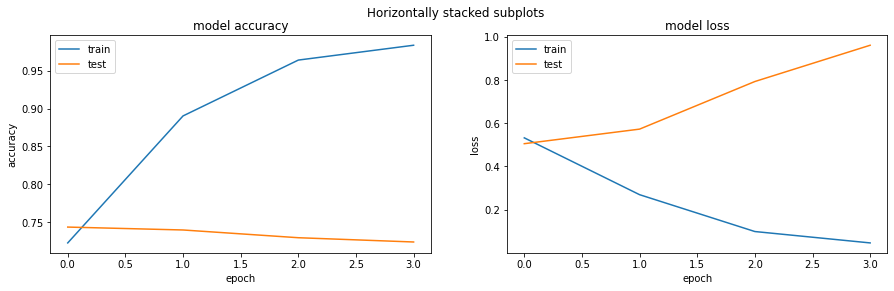

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [14]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 17s 24ms/step - loss: 0.5052 - accuracy: 0.7434


[0.5051833391189575, 0.7434201836585999]

# LSTM NN 3

In [15]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

xbi = LSTM(30, return_sequences=True)(x)
x = add([x, xbi])
xbi = LSTM(30, return_sequences=True)(x)
x = add([x, xbi])
xbi = LSTM(30, return_sequences=True)(x)
x = add([x, xbi])


x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 27, 30)       7743240     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 27, 30)       7320        embedding_2[0][0]                
__________________________________________________________________________________________________
add_1 (Add)                     (None, 27, 30)       0           embedding_2[0][0]                
                                                                 lstm_2[0][0]               

Epoch 1/25
709/709 [==============================] - 368s 505ms/step - loss: 0.5322 - accuracy: 0.7235 - val_loss: 0.5013 - val_accuracy: 0.7502
Epoch 2/25
709/709 [==============================] - 348s 490ms/step - loss: 0.2719 - accuracy: 0.8879 - val_loss: 0.5882 - val_accuracy: 0.7415
Epoch 3/25
709/709 [==============================] - 337s 475ms/step - loss: 0.1060 - accuracy: 0.9608 - val_loss: 0.8011 - val_accuracy: 0.7282
Epoch 4/25
709/709 [==============================] - 342s 482ms/step - loss: 0.0547 - accuracy: 0.9800 - val_loss: 1.0617 - val_accuracy: 0.7234


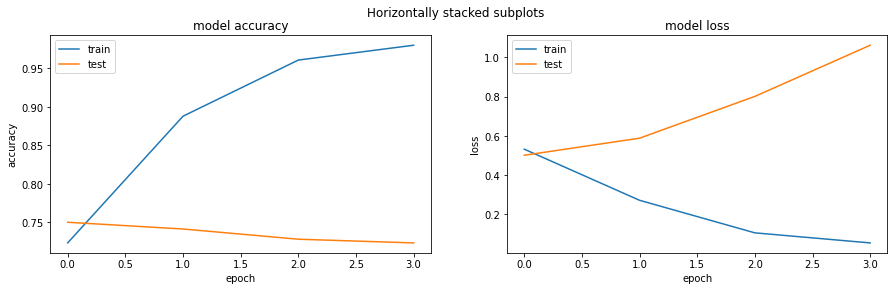

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [17]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 21s 30ms/step - loss: 0.5013 - accuracy: 0.7502


[0.5012919902801514, 0.750209391117096]

# CNN 1

In [18]:
#dim = int((word_count)**(1/2))
dim = 30

inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=dim,
              trainable=True,
              mask_zero=True)(inputs)

x = Conv1D(128, 3, activation='relu')(x)

x = GlobalMaxPool1D()(x)
#x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 27, 30)            7743240   
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 128)           11648     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65  

Epoch 1/25
709/709 [==============================] - 44s 60ms/step - loss: 0.5430 - accuracy: 0.7135 - val_loss: 0.5015 - val_accuracy: 0.7479
Epoch 2/25
709/709 [==============================] - 42s 59ms/step - loss: 0.2938 - accuracy: 0.8801 - val_loss: 0.5902 - val_accuracy: 0.7346
Epoch 3/25
709/709 [==============================] - 42s 59ms/step - loss: 0.1076 - accuracy: 0.9626 - val_loss: 0.7949 - val_accuracy: 0.7303
Epoch 4/25
709/709 [==============================] - 41s 58ms/step - loss: 0.0445 - accuracy: 0.9854 - val_loss: 0.9728 - val_accuracy: 0.7264


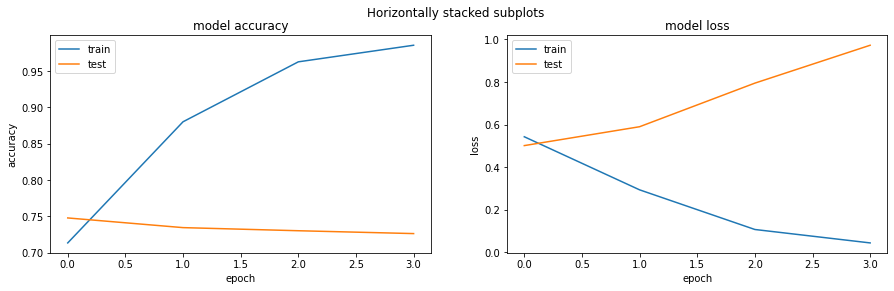

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [20]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 1s 2ms/step - loss: 0.5015 - accuracy: 0.7479


[0.5015478730201721, 0.7478728294372559]

# CNN 2

In [21]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = Conv1D(filters, 3, padding="same")(x)
        x = Activation(activation)(x)
    x = Conv1D(filters, 3, padding="same")(x)
    x = add([x, s])
    x = Activation(activation)(x)
    return MaxPool1D(pool_size=2, strides=2)(x)



def build_model(X_train):
    inputs = Input(shape=(X_train.shape[1],))
    
    x = tf.keras.layers.Reshape((27, 1))(inputs)

    x = residual_block(x, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)

    x = AveragePooling1D(pool_size=3, strides=3)(x)
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)

    outputs = Dense(1, activation="sigmoid", name="output")(x)

    
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model 


In [22]:
model = build_model(X_train)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 27, 1)        0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 27, 16)       64          reshape[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 27, 16)       0           conv1d_2[0][0]                   
____________________________________________________________________________________________

Epoch 1/25
709/709 [==============================] - 7s 9ms/step - loss: 12.8270 - accuracy: 0.5343 - val_loss: 1.0589 - val_accuracy: 0.5244
Epoch 2/25
709/709 [==============================] - 6s 8ms/step - loss: 1.3024 - accuracy: 0.5464 - val_loss: 0.7510 - val_accuracy: 0.5382
Epoch 3/25
709/709 [==============================] - 6s 8ms/step - loss: 0.8260 - accuracy: 0.5556 - val_loss: 0.7321 - val_accuracy: 0.5229
Epoch 4/25
709/709 [==============================] - 6s 8ms/step - loss: 0.7334 - accuracy: 0.5584 - val_loss: 0.7263 - val_accuracy: 0.5142
Epoch 5/25
709/709 [==============================] - 6s 8ms/step - loss: 0.6880 - accuracy: 0.5758 - val_loss: 0.7222 - val_accuracy: 0.5447
Epoch 6/25
709/709 [==============================] - 6s 9ms/step - loss: 0.6753 - accuracy: 0.5837 - val_loss: 0.7200 - val_accuracy: 0.5401
Epoch 7/25
709/709 [==============================] - 6s 8ms/step - loss: 0.6696 - accuracy: 0.5907 - val_loss: 0.7115 - val_accuracy: 0.5453
Epoch

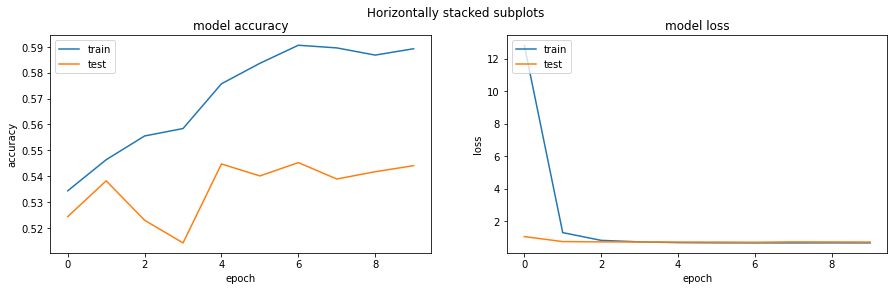

In [23]:
history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [24]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 3s 4ms/step - loss: 0.7115 - accuracy: 0.5453


[0.7115185260772705, 0.5452541708946228]

# CNN+LSTM

In [25]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

x = (Conv1D(filters=64, kernel_size=3, activation='relu', padding="same"))(x)

x = LSTM(64, return_sequences=True)(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 27, 30)            7743240   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 27, 64)            5824      
_________________________________________________________________
lstm_5 (LSTM)                (None, 27, 64)            33024     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                110656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0   

Epoch 1/25
709/709 [==============================] - 45s 61ms/step - loss: 0.5339 - accuracy: 0.7218 - val_loss: 0.4944 - val_accuracy: 0.7512
Epoch 2/25
709/709 [==============================] - 42s 60ms/step - loss: 0.2766 - accuracy: 0.8869 - val_loss: 0.5811 - val_accuracy: 0.7427
Epoch 3/25
709/709 [==============================] - 42s 59ms/step - loss: 0.1121 - accuracy: 0.9589 - val_loss: 0.8000 - val_accuracy: 0.7331
Epoch 4/25
709/709 [==============================] - 42s 60ms/step - loss: 0.0521 - accuracy: 0.9812 - val_loss: 1.1080 - val_accuracy: 0.7291


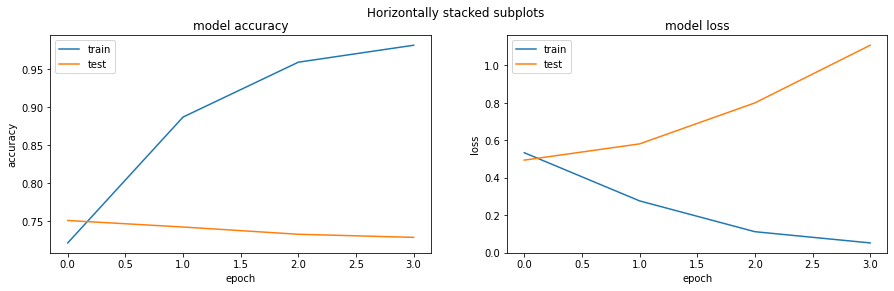

In [26]:
history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [27]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 2s 3ms/step - loss: 0.4944 - accuracy: 0.7512


[0.4943791329860687, 0.7512233853340149]

# ConvLSTM2D

In [28]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)


x = tf.keras.layers.Reshape((27, 30, 1, 1))(x)
x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', padding="same")(x)


x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 27, 30)            7743240   
_________________________________________________________________
reshape_1 (Reshape)          (None, 27, 30, 1, 1)      0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 30, 1, 64)         33536     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                122944    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0   

Epoch 1/25
709/709 [==============================] - 371s 518ms/step - loss: 0.5542 - accuracy: 0.7093 - val_loss: 0.5040 - val_accuracy: 0.7484
Epoch 2/25
709/709 [==============================] - 370s 522ms/step - loss: 0.3357 - accuracy: 0.8616 - val_loss: 0.5510 - val_accuracy: 0.7461
Epoch 3/25
709/709 [==============================] - 371s 523ms/step - loss: 0.1736 - accuracy: 0.9344 - val_loss: 0.7410 - val_accuracy: 0.7305
Epoch 4/25
709/709 [==============================] - 366s 517ms/step - loss: 0.1038 - accuracy: 0.9616 - val_loss: 0.9858 - val_accuracy: 0.7217


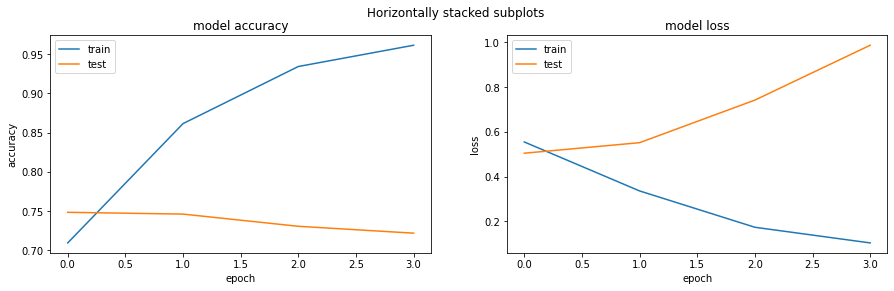

In [29]:
history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [30]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 22s 31ms/step - loss: 0.5040 - accuracy: 0.7484


[0.5040243864059448, 0.7483577728271484]

# LSTM + CNN

In [31]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)


x = LSTM(64, return_sequences=True)(x)
x = (Conv1D(filters=64, kernel_size=3, activation='relu', padding="same"))(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 27, 30)            7743240   
_________________________________________________________________
lstm_6 (LSTM)                (None, 27, 64)            24320     
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 27, 64)            12352     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                110656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0   

Epoch 1/25
709/709 [==============================] - 140s 192ms/step - loss: 0.5334 - accuracy: 0.7230 - val_loss: 0.4965 - val_accuracy: 0.7547
Epoch 2/25
709/709 [==============================] - 136s 192ms/step - loss: 0.2841 - accuracy: 0.8833 - val_loss: 0.6536 - val_accuracy: 0.7416
Epoch 3/25
709/709 [==============================] - 136s 191ms/step - loss: 0.1284 - accuracy: 0.9521 - val_loss: 0.8383 - val_accuracy: 0.7345
Epoch 4/25
709/709 [==============================] - 136s 192ms/step - loss: 0.0699 - accuracy: 0.9738 - val_loss: 1.0798 - val_accuracy: 0.7231


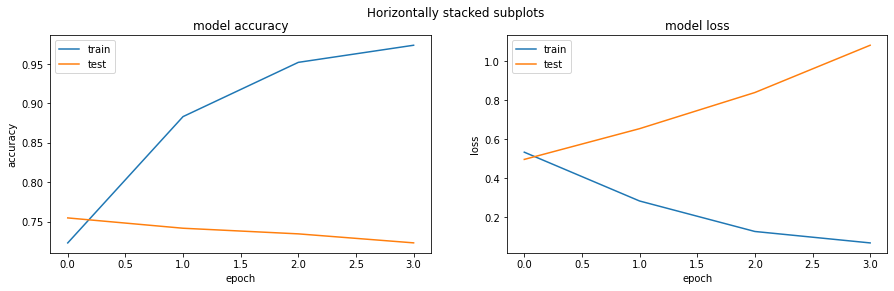

In [32]:
history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [33]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 8s 12ms/step - loss: 0.4965 - accuracy: 0.7547


[0.4965296685695648, 0.7547061443328857]

# Выводы.

Лучше всего сработали (в порядке убывания результата) следующие архитектуры:

    1. LSTM + CNN
    2. CNN + LSTM
    3. Стекинг из LSTM с residual connection.
    
При этом их результаты не сильно отличались и однозначно сказать что какая то архитектура лучше других нельзя.

__P.S.__ Качество на тесте практически всех моделей падало после первой же эпохи. Это говорит о возможном переобучении уже в течении выполнения первой эпохи. Может быть имело смысл уменьшить размер датасета на трейне или хотя бы размер батча.